* すべてのデータを使って教師ありで学習

In [ ]:
# すべてのデータを使って教師ありで学習
import os
import sys
import json
import logging
import resource
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from IOHMM import SemiSupervisedIOHMM     # ← ここを変更
from IOHMM import CrossEntropyMNL, DiscreteMNL

import pickle

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

import numpy as np
from IOHMM import CrossEntropyMNL



In [2]:
# %% [2] リソース制限関数
def set_limits(max_mem_mb=None, max_cpu_sec=None):
    """MB と秒で RLIMIT を貼る。None なら制限なし。"""
    if max_mem_mb:
        mb = max_mem_mb * 1024 * 1024
        resource.setrlimit(resource.RLIMIT_AS, (mb, mb))
        logging.info(f"RLIMIT_AS={max_mem_mb}MB")
    if max_cpu_sec:
        resource.setrlimit(resource.RLIMIT_CPU, (max_cpu_sec, max_cpu_sec))
        logging.info(f"RLIMIT_CPU={max_cpu_sec}s")


In [3]:
import numpy as np
from IOHMM import DiscreteMNL

class SmoothedDiscreteMNL(DiscreteMNL):
    def __init__(self, solver='lbfgs', alpha=1.0, **kw):
        super().__init__(solver=solver, **kw)
        self.alpha = alpha

    def predict_log_proba(self, X):
        # Multi‐nomial の元の log-prob
        logp = super().predict_log_proba(X)      # (n_samples, n_classes)
        p    = np.exp(logp)
        # smoothing
        p += self.alpha
        p /= p.sum(axis=1, keepdims=True)
        return np.log(p)

    def loglike_per_sample(self, X, y):
        # IOHMM の E_step から呼ばれるのはここ
        y_idx = y.ravel().astype(int)
        lp    = self.predict_log_proba(X)
        return lp[np.arange(len(y_idx)), y_idx]


In [26]:
def a(path_csv):
    logging.info("データ読み込み…")
    df = pd.read_csv(path_csv)
    # 必要カラムチェック
    required = ['balls','strikes','pitch_type','zone_cluster',
                'pitch_cluster_label','zone','pitcher','game_pk']
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise RuntimeError(f"Missing columns: {missing}")

    # --- 欠損値除去 ---
    df = df.dropna(subset=['pitch_cluster_label', 'zone_cluster']).reset_index(drop=True)

    # --- 各種 LabelEncoder ---
    le_pt = LabelEncoder().fit(df['pitch_type'])
    le_z  = LabelEncoder().fit(df['zone'])
    le_pcl = LabelEncoder().fit(df['pitch_cluster_label'])
    le_zcl = LabelEncoder().fit(df['zone_cluster'])

    return le_pt,le_z,le_pcl,le_zcl 

In [ ]:
# %% [3] データ読み込み＆前処理
def load_and_prepare(path_csv):
    logging.info("データ読み込み…")
    df = pd.read_csv(path_csv)
    # 必要カラムチェック
    required = ['balls','strikes','pitch_type','zone_cluster',
                'pitch_cluster_label','zone','pitcher','game_pk']
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise RuntimeError(f"Missing columns: {missing}")

    # --- 欠損値除去 ---
    df = df.dropna(subset=['pitch_cluster_label', 'zone_cluster']).reset_index(drop=True)

    # --- 各種 LabelEncoder ---
    le_pt = LabelEncoder().fit(df['pitch_type'])
    le_z  = LabelEncoder().fit(df['zone'])
    le_pcl = LabelEncoder().fit(df['pitch_cluster_label'])
    le_zcl = LabelEncoder().fit(df['zone_cluster'])

    # transform
    df['pitch_type']          = le_pt.transform(df['pitch_type'])
    df['zone']                = le_z.transform(df['zone'])
    df['pitch_cluster_label'] = le_pcl.transform(df['pitch_cluster_label'])
    df['zone_cluster']        = le_zcl.transform(df['zone_cluster'])

    # emission クラス数
    n_classes_emis0 = len(le_pcl.classes_)
    n_classes_emis1 = len(le_zcl.classes_)
    logging.info(f"Emission0(classes): {n_classes_emis0}, Emission1(classes): {n_classes_emis1}")

    # --- 隠れ状態 = zone のみ ---
    df['state_id'] = df['zone']
    num_states = df['state_id'].nunique()
    logging.info(f"hidden states: {num_states} (zones)")

    # --- シーケンス辞書を作成（投球数 >= 2 のものだけ）---
    seqs = {
        f"{p}_game_{g}": gdf.reset_index(drop=True)
        for (p, g), gdf in df.groupby(['pitcher','game_pk'])
        if len(gdf) >= 2
    }

    # --- pitcher → [キー一覧] のマッピングを作成 ---
    from collections import defaultdict
    pitch_to_keys = defaultdict(list)
    for key in seqs.keys():
        pitcher = key.split('_game_')[0]
        pitch_to_keys[pitcher].append(key)

    # --- 各投手ごとに 8:2 で分割 ---
    train_keys, test_keys = [], []
    for pitcher, keys in pitch_to_keys.items():
        if len(keys) >= 2:
            t_keys, v_keys = train_test_split(
                keys, test_size=0.2, random_state=42
            )
        else:
            # １試合しかない投手はすべて train に
            t_keys, v_keys = keys, []
        train_keys += t_keys
        test_keys  += v_keys

    logging.info(f"train/test sequences: {len(train_keys)}/{len(test_keys)}")

    # --- train 用 dfs_states ---
    eye = np.eye(num_states)
    dfs_states = []
    for k in train_keys:
        s = seqs[k]
        state_map = {t: eye[z] for t, z in zip(s.index, s['zone'])}
        dfs_states.append([s, state_map])

    # --- test 用 dfs_states（ラベル隠し or 空辞書）---
    test_dfs_states = []
    for k in test_keys:
        s = seqs[k]
        test_dfs_states.append([s, {}])

    return dfs_states,  num_states, n_classes_emis0, n_classes_emis1,test_dfs_states,le_z,le_pcl,

In [5]:
# %% [4] 半教師ありモデル構築＆学習
def build_and_train(dfs_states, num_states,
                    n_classes_emis0, n_classes_emis1,
                    save_dir="iohmm_sup_model"):
    logging.info("SemiSupervisedIOHMM モデル構築…")
    shmm = SemiSupervisedIOHMM(num_states=num_states)

    # Emission に DiscreteMNL を使う（クロスエントロピー損失）
    shmm.set_models(
        model_emissions=[
            SmoothedDiscreteMNL(solver='lbfgs', alpha=1.0),
            SmoothedDiscreteMNL(solver='lbfgs', alpha=1.0)
        ],
        model_transition=CrossEntropyMNL(solver='lbfgs'),
        model_initial=   CrossEntropyMNL(solver='lbfgs'),
    )

    covs = ['balls','strikes']
    shmm.set_inputs(
        covariates_initial=covs,
        covariates_transition=covs,
        covariates_emissions=[covs, covs]
    )
    shmm.set_outputs([['pitch_cluster_label'], ['zone_cluster']])

    logging.info("データをセット…")
    shmm.set_data(dfs_states)

    logging.info("EM 学習開始…")
    shmm.train()   # 半教師ありなので EM を繰り返す
    logging.info(f"学習完了。対数尤度 = {shmm.log_likelihood:.4f}")

    # モデル保存
    os.makedirs(save_dir, exist_ok=True)
    with open(os.path.join(save_dir, 'model_zoneonly.pkl'), 'wb') as f:
        pickle.dump(shmm, f)
    logging.info("モデルを pickle で保存しました。")


In [6]:
# %% [5] 実行セル
if __name__ == '__main__':
    set_limits(max_mem_mb=32000)
    dfs_states, num_states, n0, n1,test_dfs_states = load_and_prepare('df_clean_zone_cluster.csv')
    build_and_train(dfs_states, num_states, n0, n1)

2025-05-17 22:45:04,780 INFO RLIMIT_AS=32000MB
2025-05-17 22:45:04,781 INFO データ読み込み…
2025-05-17 22:45:42,695 INFO Emission0(classes): 5, Emission1(classes): 5
2025-05-17 22:45:42,716 INFO hidden states: 13 (zones)
2025-05-17 22:46:12,833 INFO train/test sequences: 77360/20063
2025-05-17 22:46:17,893 INFO SemiSupervisedIOHMM モデル構築…
2025-05-17 22:46:17,900 INFO データをセット…
2025-05-17 22:48:38,695 INFO EM 学習開始…
2025-05-17 23:41:59,031 INFO log likelihood of iteration 0: -7475537.8990
2025-05-18 00:35:04,672 INFO log likelihood of iteration 1: -7475537.8990
2025-05-18 00:35:04,673 INFO 学習完了。対数尤度 = -7475537.8990
2025-05-18 00:35:34,381 INFO モデルを pickle で保存しました。


In [94]:
if __name__ == '__main__':
    le_pt,le_z,le_pcl,le_zcl = a('df_clean_zone_cluster.csv')

2025-05-20 14:39:40,857 INFO データ読み込み…


In [95]:
import pickle
with open('iohmm_sup_model/model_zoneonly.pkl', 'rb') as f:
    shmm_loaded = pickle.load(f)
#print("復元後の対数尤度:", shmm_loaded.log_likelihood)


In [96]:
shmm_loaded.set_data(test_dfs_states)
shmm_loaded.E_step()

In [ ]:
posterior_paths = [np.argmax(logg, axis=1) 
                   for logg in shmm_loaded.log_gammas]


In [10]:
y_true_pitch, y_pred_pitch = [], []
y_true_zonecl,  y_pred_zonecl = [], []

for (df, _), path in zip(test_dfs_states, posterior_paths):
    # covariate 行列 (T×2): balls, strikes
    X = df[['balls','strikes']].values  
    # 真のラベル
    y_true_pitch.append(df['pitch_cluster_label'].values)
    y_true_zonecl .append(df['zone_cluster'].values)

    # 予測したラベル
    pred_p, pred_z = [], []
    for t, s in enumerate(path):
        # emission=0: pitch_cluster_label モデル
        logp0 = shmm_loaded.model_emissions[s][0].predict_log_proba(X[t].reshape(1,-1))
        pred_p.append(int(np.argmax(np.exp(logp0))))
        # emission=1: zone_cluster モデル
        logp1 = shmm_loaded.model_emissions[s][1].predict_log_proba(X[t].reshape(1,-1))
        pred_z.append(int(np.argmax(np.exp(logp1))))

    y_pred_pitch.append(np.array(pred_p))
    y_pred_zonecl.append(np.array(pred_z))

In [12]:
from sklearn.metrics import accuracy_score

y_true_p = np.hstack(y_true_pitch)
y_pred_p = np.hstack(y_pred_pitch)
y_true_z = np.hstack(y_true_zonecl)
y_pred_z = np.hstack(y_pred_zonecl)

acc_p = accuracy_score(y_true_p, y_pred_p)
acc_z = accuracy_score(y_true_z, y_pred_z)
print("球種クラスタ予測精度:", round(acc_p, 4))
print("ゾーンクラスタ予測精度:", round(acc_z, 4))

球種クラスタ予測精度: 0.3732
ゾーンクラスタ予測精度: 0.4753


In [58]:
import matplotlib.font_manager as fm

# 日本語対応フォント候補を抽出して表示
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if any(x in font.lower() for x in ['gothic', 'meiryo', 'noto', 'ipa', 'takao']):
        print(font)


/usr/share/fonts/opentype/urw-base35/URWGothic-BookOblique.otf
/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf
/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf
/usr/share/fonts/meiryo/meiryo.ttc
/usr/share/fonts/opentype/ipafont-mincho/ipam.ttf
/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc
/usr/share/fonts/opentype/urw-base35/URWGothic-Book.otf
/usr/share/fonts/truetype/takao-gothic/TakaoGothic.ttf
/usr/share/fonts/truetype/fonts-japanese-gothic.ttf
/usr/share/fonts/truetype/noto/NotoSansMono-Bold.ttf
/usr/share/fonts/opentype/urw-base35/URWGothic-DemiOblique.otf
/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc
/usr/share/fonts/opentype/noto/NotoSerifCJK-SemiBold.ttc
/usr/share/fonts/opentype/noto/NotoSansCJK-Black.ttc
/usr/share/fonts/opentype/ipafont-mincho/ipamp.ttf
/usr/share/fonts/opentype/urw-base35/URWGothic-Demi.otf
/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf
/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc
/usr/share/fonts/truetype/noto/NotoColor

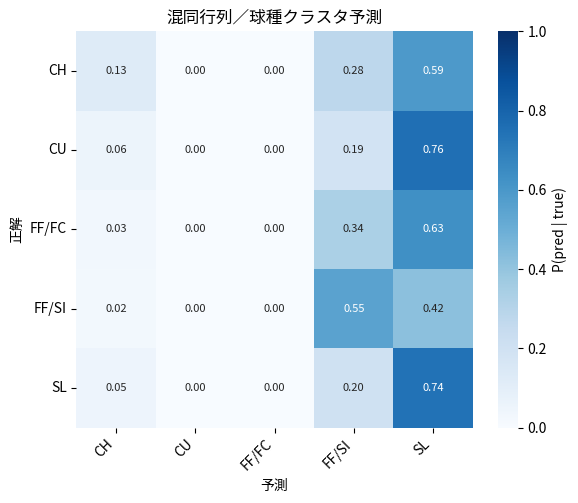

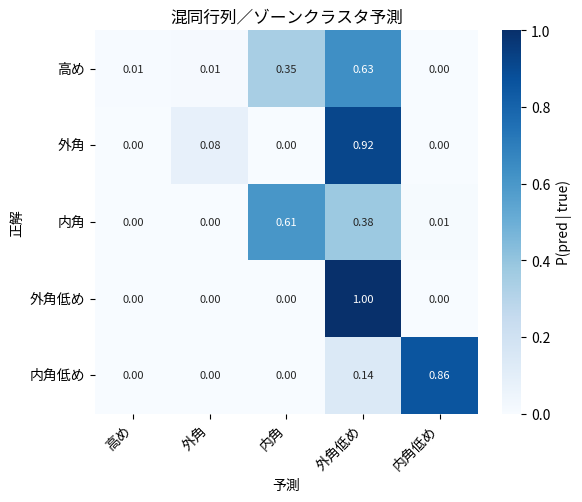

In [111]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties

# 1) flatten
y_true_p = np.hstack(y_true_pitch)
y_pred_p = np.hstack(y_pred_pitch)
y_true_z = np.hstack(y_true_zonecl)
y_pred_z = np.hstack(y_pred_zonecl)

# 2) 混同行列の計算（行＝真, 列＝予測, 行正規化）
cm_p = confusion_matrix(y_true_p, y_pred_p, normalize='true')
cm_z = confusion_matrix(y_true_z, y_pred_z, normalize='true')

# 3) ラベルを戻す
#   pitch_cluster_label 用の Encoder（学習時に使ったもの）を使ってクラス名取得
pitch_labels = le_pcl.inverse_transform(np.arange(len(le_pcl.classes_)))
#   zone_cluster 用の Encoder
zone_labels  = le_zcl.inverse_transform(np.arange(len(le_zcl.classes_)))

# 4) 可視化関数
def plot_cm(cm, labels, title):
    jp_font = FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-DemiLight.ttc')
    rcParams['font.family'] = jp_font.get_name()
    rcParams['axes.unicode_minus'] = False  # マイナス記号の文字化け対策
    plt.figure(figsize=(6,5))
    
    sns.heatmap(
        cm,
        cmap="Blues",
        vmin=0, vmax=1,
        annot=True,         # ← 数字をセル内に表示
        fmt=".2f",          # ← 小数点2桁表示
        annot_kws={"size":8},
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={"label": "P(pred | true)"},
        square=True
    )
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.xlabel("予測")
    plt.ylabel("正解")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 5) 描画
plot_cm(cm_p, pitch_labels, "混同行列／球種クラスタ予測")
plot_cm(cm_z, new_xticklabels,  "混同行列／ゾーンクラスタ予測")


In [13]:
records = []
for (df, _), true_p, pred_p, true_z, pred_z in zip(
        test_dfs_states,
        y_true_pitch, y_pred_pitch,
        y_true_zonecl, y_pred_zonecl
    ):
    pitcher = df['pitcher'].iloc[0]
    game_pk = df['game_pk'].iloc[0]
    acc_p   = accuracy_score(true_p, pred_p)
    acc_z   = accuracy_score(true_z, pred_z)
    records.append({
        'pitcher': pitcher,
        'game_pk': game_pk,
        'acc_pitch_cluster': acc_p,
        'acc_zone_cluster':  acc_z
    })

df_acc = pd.DataFrame(records)

In [14]:
pitcher_summary = (
    df_acc
    .groupby('pitcher')
    .agg(
        mean_acc_pitch_cluster=('acc_pitch_cluster', 'mean'),
        mean_acc_zone_cluster =('acc_zone_cluster',  'mean'),
        n_games               =('game_pk',           'count')
    )
    .sort_values('mean_acc_zone_cluster', ascending=False)
)

# 3) 結果を表示（上位20投手など）
print(pitcher_summary.head(20))

         mean_acc_pitch_cluster  mean_acc_zone_cluster  n_games
pitcher                                                        
676754                 0.666667               1.000000        1
678576                 0.500000               1.000000        1
669697                 0.833333               1.000000        1
667435                 0.571429               0.857143        1
658667                 0.428571               0.857143        1
630263                 0.697802               0.846154        2
666661                 0.684211               0.842105        1
701552                 0.166667               0.833333        1
656349                 0.666667               0.833333        1
592165                 0.435049               0.822304        2
696275                 0.687500               0.812500        1
596035                 0.645604               0.807692        2
516853                 0.384615               0.807692        1
622110                 0.000000         

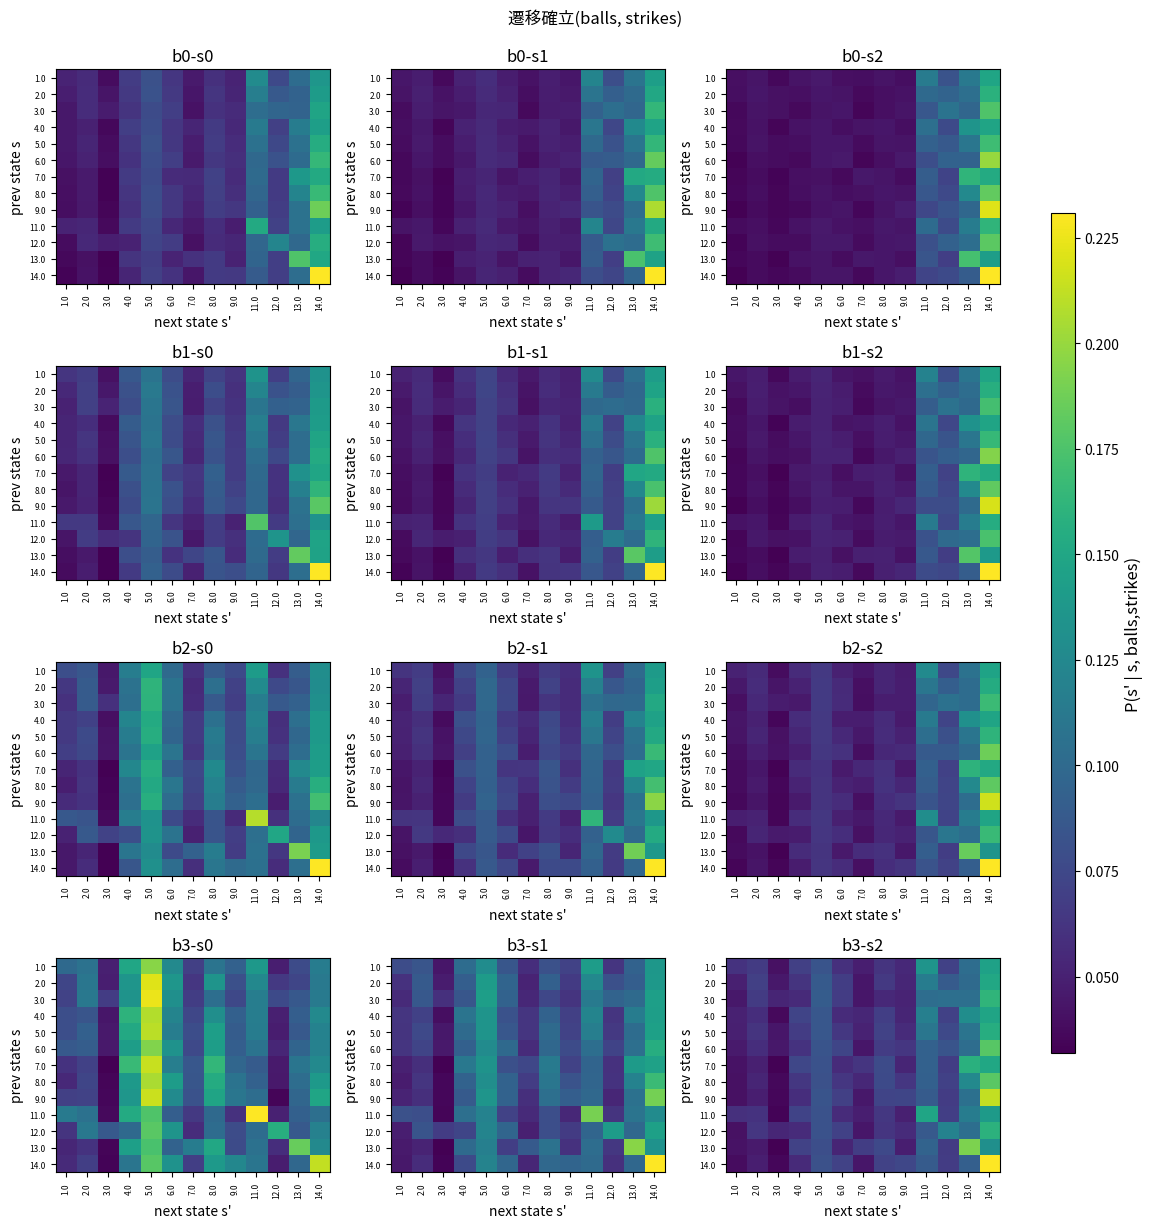

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

state_ids  = np.arange(shmm_loaded.num_states)
state_labels = le_z.inverse_transform(state_ids)
# shmm_loaded: 読み込んだ IOHMM モデル
# covariate の全パターン
covs = [(b, s) for b in range(4) for s in range(3)]  # b=0,1,2,3; s=0,1,2
n_states = shmm_loaded.num_states

fig, axes = plt.subplots(4, 3, figsize=(12, 12))

for idx, (b, s) in enumerate(covs):
    ax = axes.flat[idx]
    # 各前状態 st からの遷移確率を集める
    # model_transition[st].predict_log_proba は shape=(1, n_states) の log-prob を返すので
    # exp → (n_states,) にして縦方向に積む
    trans_mat = np.vstack([
        np.exp(shmm_loaded.model_transition[st]
               .predict_log_proba(np.array([[b, s]])))[0]
        for st in range(n_states)
    ])  # shape = (n_states, n_states)

    # 各行列ごとに最小・最大を取ってノーマライズ
    vmin, vmax = trans_mat.min(), trans_mat.max()
    im = ax.imshow(trans_mat,
                   vmin=vmin, vmax=vmax,
                   aspect='auto',
                   cmap=cm.viridis)
    ax.set_title(f"b{b}-s{s}")
    ax.set_xticks(np.arange(n_states))
    ax.set_yticks(np.arange(n_states))
    ax.set_xticklabels(state_labels, rotation=90, fontsize=6)
    ax.set_yticklabels(state_labels,           fontsize=6)
    ax.set_xlabel("next state s'")
    ax.set_ylabel("prev state s")

# for j in range(n_cov, n_rows*n_cols):
    # axes.flat[j].axis('off')

    # 各サブプロットに個別のカラーバーをつけたければ以下をアンコメント
    # plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(rect=[0.00, 0.00, 0.85, 1.00])
# 全体のカラーバーを右側にまとめて出す場合：
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("P(s' | s, balls,strikes)", fontsize=12)

plt.suptitle("遷移確立(balls, strikes)", y=1.02)
plt.show()


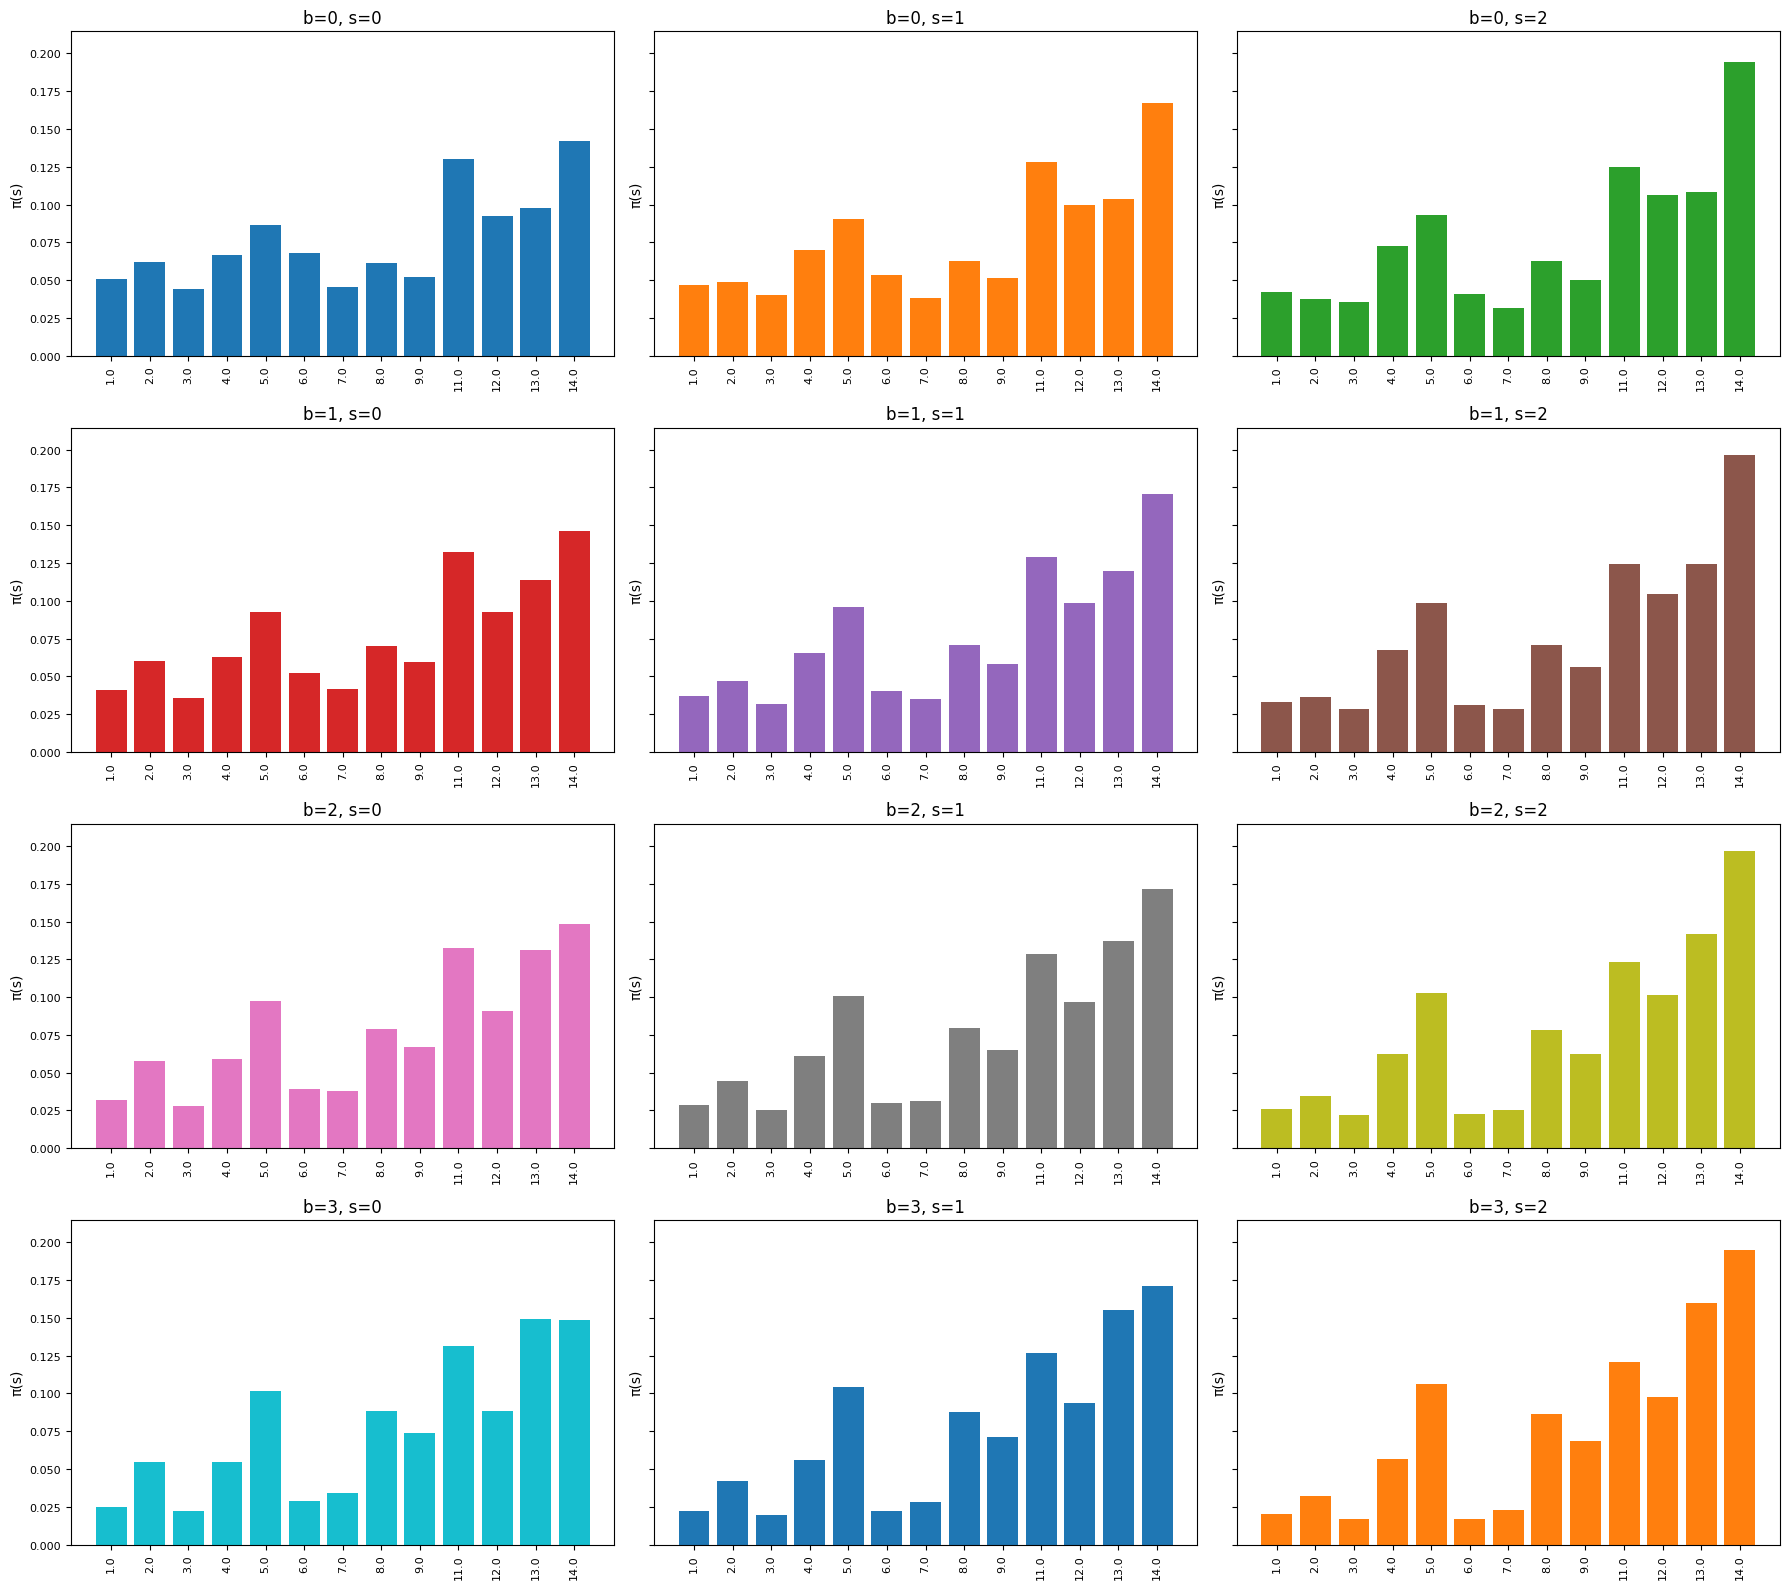

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# state_labels：エンコード前の zone ラベル
state_ids    = np.arange(shmm_loaded.num_states)
state_labels = le_z.inverse_transform(state_ids)

# covariate 全パターン
covs = [(b, s) for b in range(4) for s in range(3)]
n_cov = len(covs)
n_cols = 3
n_rows = int(np.ceil(n_cov / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows), sharey=True)
axes = axes.flatten()

for idx, (b, s) in enumerate(covs):
    ax = axes[idx]
    # π(s | b,s) を取得
    pi = np.exp(
        shmm_loaded.model_initial
                  .predict_log_proba(np.array([[b, s]]))
    ).flatten()
    
    # x軸用の数値インデックスを作る
    x = np.arange(len(state_labels))
    ax.bar(x, pi, color=f"C{idx%10}")
    
    ax.set_title(f"b={b}, s={s}", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(state_labels, rotation=90, fontsize=8)
    
    ax.set_ylabel("π(s)", fontsize=10)
    ax.set_ylim(0, pi.max()*1.1)
    ax.yaxis.set_tick_params(labelsize=8)

# 余った subplot は消す
for j in range(n_cov, n_rows*n_cols):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


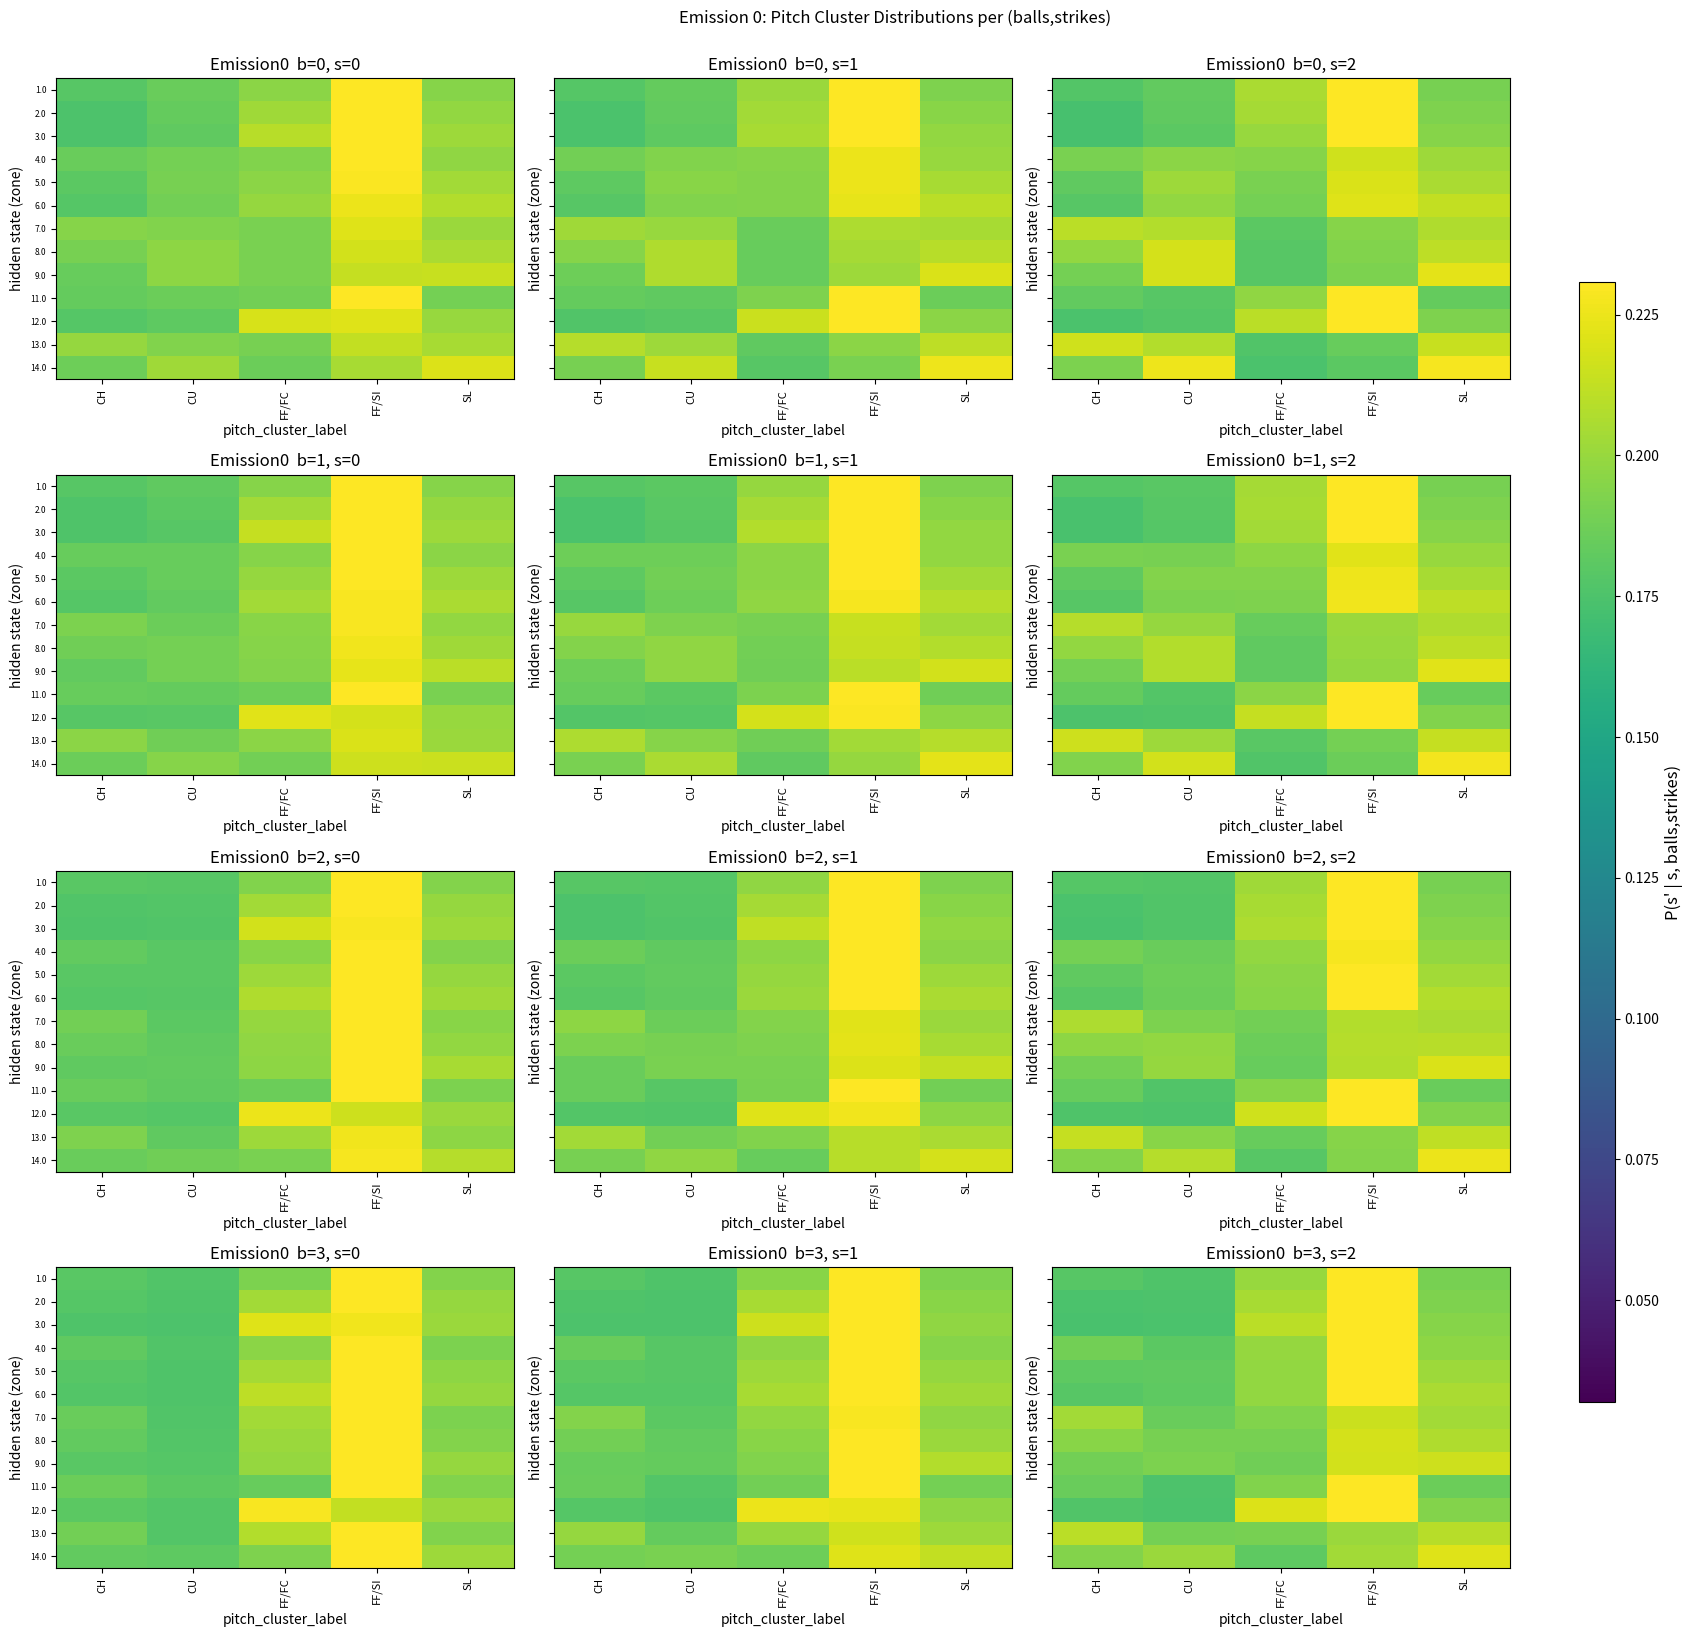

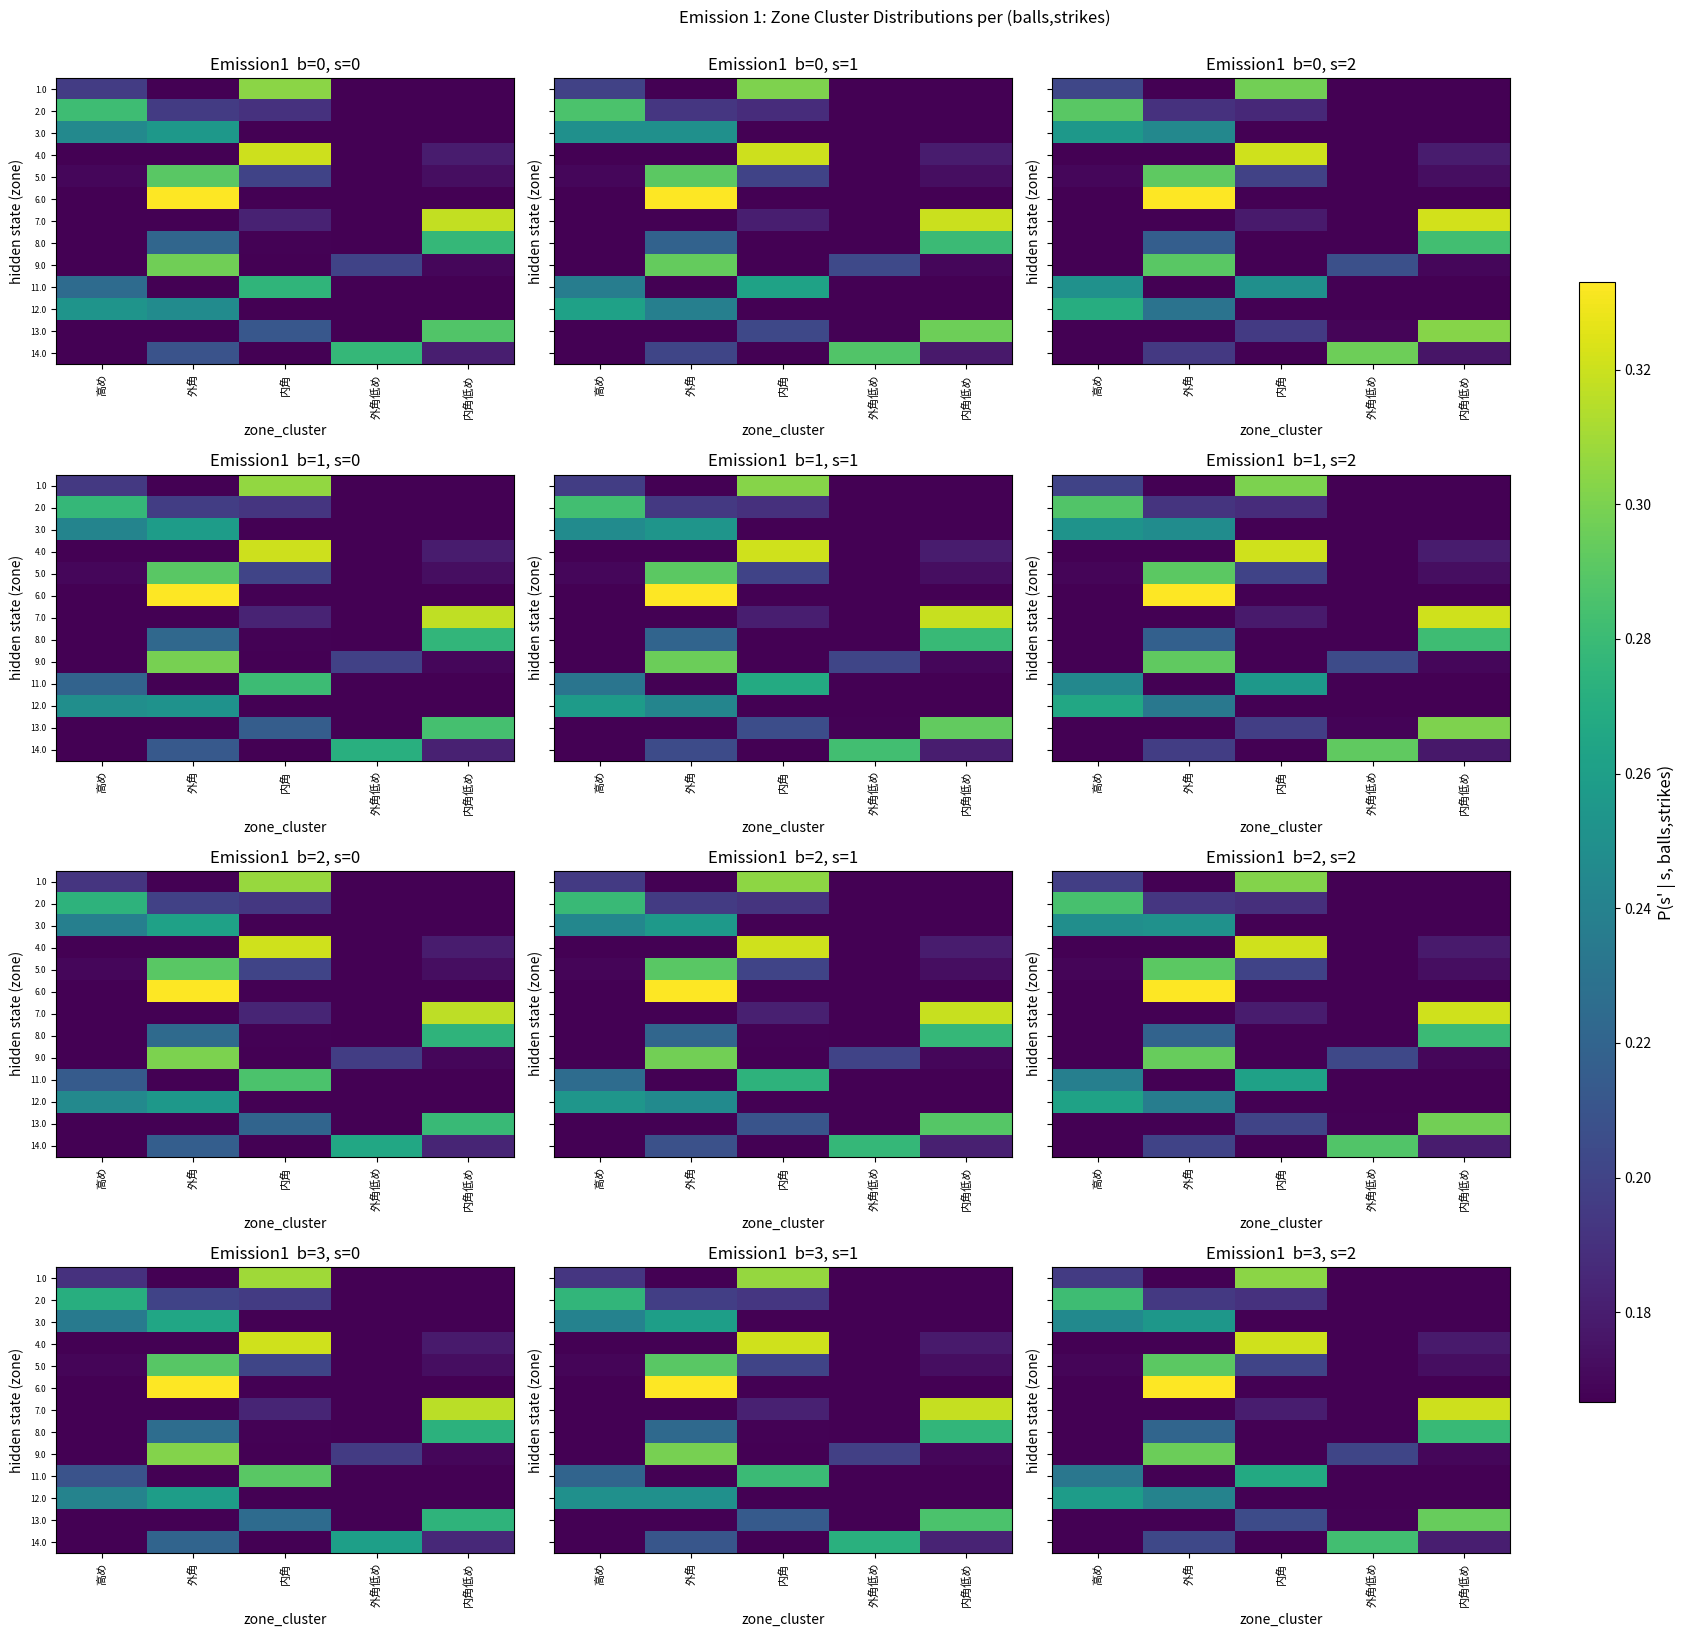

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# --- 前準備 ---
# 1) 隠れ状態の名前（zone）を戻す
state_ids    = np.arange(shmm_loaded.num_states)
state_labels = le_z.inverse_transform(state_ids)

# 2) 出力クラスの名前を戻す
class0_labels = le_pcl.inverse_transform(np.arange(len(le_pcl.classes_)))
class1_labels = le_zcl.inverse_transform(np.arange(len(le_zcl.classes_)))

# 3) 全 covariate パターン（0-0 を除外しているのでご注意）
covs = [(b,s) for b in range(4) for s in range(3)]
n_cov = len(covs)
n_cols = 3
n_rows = int(np.ceil(n_cov / n_cols))

# --- Emission 0 (pitch_cluster_label) をプロット ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows), sharey=True, tight_layout=True)
axes = axes.flatten()
for idx, (b,s) in enumerate(covs):
    ax = axes[idx]
    # 各 hidden state からの出力確率ベクトルを積み重ね
    emis0_mat = np.vstack([
        np.exp(shmm_loaded.model_emissions[st][0]
               .predict_log_proba(np.array([[b,s]])))[0]
        for st in range(shmm_loaded.num_states)
    ])  # shape = (n_states, n_classes0)
    vmin, vmax = trans_mat.min(), trans_mat.max()
    im = ax.imshow(emis0_mat,
                   vmin=vmin, vmax=vmax,
                   aspect='auto',
                   cmap=cm.viridis)
    ax.set_title(f"Emission0  b={b}, s={s}")
    ax.set_xticks(np.arange(len(class0_labels)))
    ax.set_xticklabels(class0_labels, rotation=90, fontsize=8)
    ax.set_yticks(np.arange(len(state_labels)))
    ax.set_yticklabels(state_labels, fontsize=6)
    ax.set_xlabel("pitch_cluster_label")
    ax.set_ylabel("hidden state (zone)")
# 余った領域をオフ
for j in range(n_cov, n_rows*n_cols):
    axes[j].axis("off")
#cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
#cbar.set_label("P(y | state, cov)", fontsize=12)
plt.tight_layout(rect=[0.00, 0.00, 0.85, 1.00])
# 全体のカラーバーを右側にまとめて出す場合：
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("P(s' | s, balls,strikes)", fontsize=12)
plt.suptitle("Emission 0: Pitch Cluster Distributions per (balls,strikes)", y=1.02)
plt.show()


# --- Emission 1 (zone_cluster) をプロット ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows), sharey=True, tight_layout=True)
axes = axes.flatten()
label_map = {
    0: "高め",
    1: "外角",
    2: "内角",
    3: "外角低め",
    4: "内角低め"
}
new_xticks = np.arange(len(class1_labels))
new_xticklabels = [label_map[int(lbl)] for lbl in class1_labels]
all_emis = []
for idx, (b,s) in enumerate(covs):
    ax = axes[idx]
    emis1_mat = np.vstack([
        np.exp(shmm_loaded.model_emissions[st][1]
               .predict_log_proba(np.array([[b,s]])))[0]
        for st in range(shmm_loaded.num_states)
    ])  # shape = (n_states, n_classes1)
    all_emis.append(emis1_mat)
    vmin, vmax = emis1_mat.min(), emis1_mat.max()
    im = ax.imshow(emis1_mat,
                   vmin=vmin, vmax=vmax,
                   aspect='auto',
                   cmap=cm.viridis)
    ax.set_title(f"Emission1  b={b}, s={s}")
    ax.set_xticks(new_xticks)
    ax.set_xticklabels(new_xticklabels, rotation=90, fontsize=8)
    ax.set_yticks(np.arange(len(state_labels)))
    ax.set_yticklabels(state_labels, fontsize=6)
    ax.set_xlabel("zone_cluster")
    ax.set_ylabel("hidden state (zone)")
for j in range(n_cov, n_rows*n_cols):
    axes[j].axis("off")
#cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
#cbar.set_label("P(y | state, cov)", fontsize=12)
plt.tight_layout(rect=[0.00, 0.00, 0.85, 1.00])
# 全体のカラーバーを右側にまとめて出す場合：
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("P(s' | s, balls,strikes)", fontsize=12)
plt.suptitle("Emission 1: Zone Cluster Distributions per (balls,strikes)", y=1.02)
plt.show()
